### Import package and modules

In [2]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math as mh
from scipy.stats import mstats
import warnings
warnings.filterwarnings("ignore")

### Import dataset and Overview

Apply converters to change zipcode directly to `str` in the importing step.

In [3]:
set1 = pd.read_csv("C:/Users/qianm/OneDrive - University of Nebraska-Lincoln/Qianmei_STAT/Datapalooza/Data/Forranking.csv", 
                   converters={'zip': lambda x: str(x)})

In [4]:
set1.head()

,median_household_income_dollars,Percent_Unemployment_Rate,number_total_househlds,grandparent_no_parent_fam_pct,single_chi18_fam_pct,one_working_chi18_fam_pct,retir_income_pct,no_child_one_working_fam_pct,chi18_fam_pct2,total_number_civilian,zip,fips,Disability_pct
0,11757,41.2,5818,0.005156,0.148505,0.039017,0.143004,0.073737,0.081128,16969,601,72001,0.147622
1,16190,17.7,12719,0.006054,0.113138,0.048038,0.130042,0.086563,0.082947,30154,602,72003,0.078066
2,16645,22.5,19009,0.004577,0.147562,0.041664,0.158188,0.062970,0.079489,11131,603,72005,0.018597
3,13387,12.0,1959,0.047473,0.124043,0.051557,0.204186,0.112302,0.075549,4889,606,72093,0.106770
4,18741,14.7,9120,0.018969,0.108991,0.043969,0.164474,0.077522,0.088268,14906,610,72011,0.101301


In [5]:
set1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32989 entries, 0 to 32988
Data columns (total 13 columns):
median_household_income_dollars    32989 non-null int64
Percent_Unemployment_Rate          32989 non-null float64
number_total_househlds             32989 non-null int64
grandparent_no_parent_fam_pct      32420 non-null float64
single_chi18_fam_pct               32420 non-null float64
one_working_chi18_fam_pct          32420 non-null float64
retir_income_pct                   32420 non-null float64
no_child_one_working_fam_pct       32420 non-null float64
chi18_fam_pct2                     32420 non-null float64
total_number_civilian              32989 non-null int64
zip                                32989 non-null object
fips                               32989 non-null int64
Disability_pct                     32989 non-null float64
dtypes: float64(8), int64(4), object(1)
memory usage: 3.3+ MB


In [6]:
# Fix zipcode
def pad(x):
    if len(x) == 3:
        return '00'+x
    if len(x) == 4:
        return '0'+x
    if len(x) == 5:
        return x

In [7]:
set1['zipcode'] = set1['zip'].apply(pad)
set2 = set1.drop(['zip', 'fips', 'total_number_civilian', 'zipcode'], axis = 1)

### EDA - corr, data distribution

In [8]:
#set1.drop(['total_number_civilian','fips'], axis = 1, inplace = True)
t1cor = set2.corr()

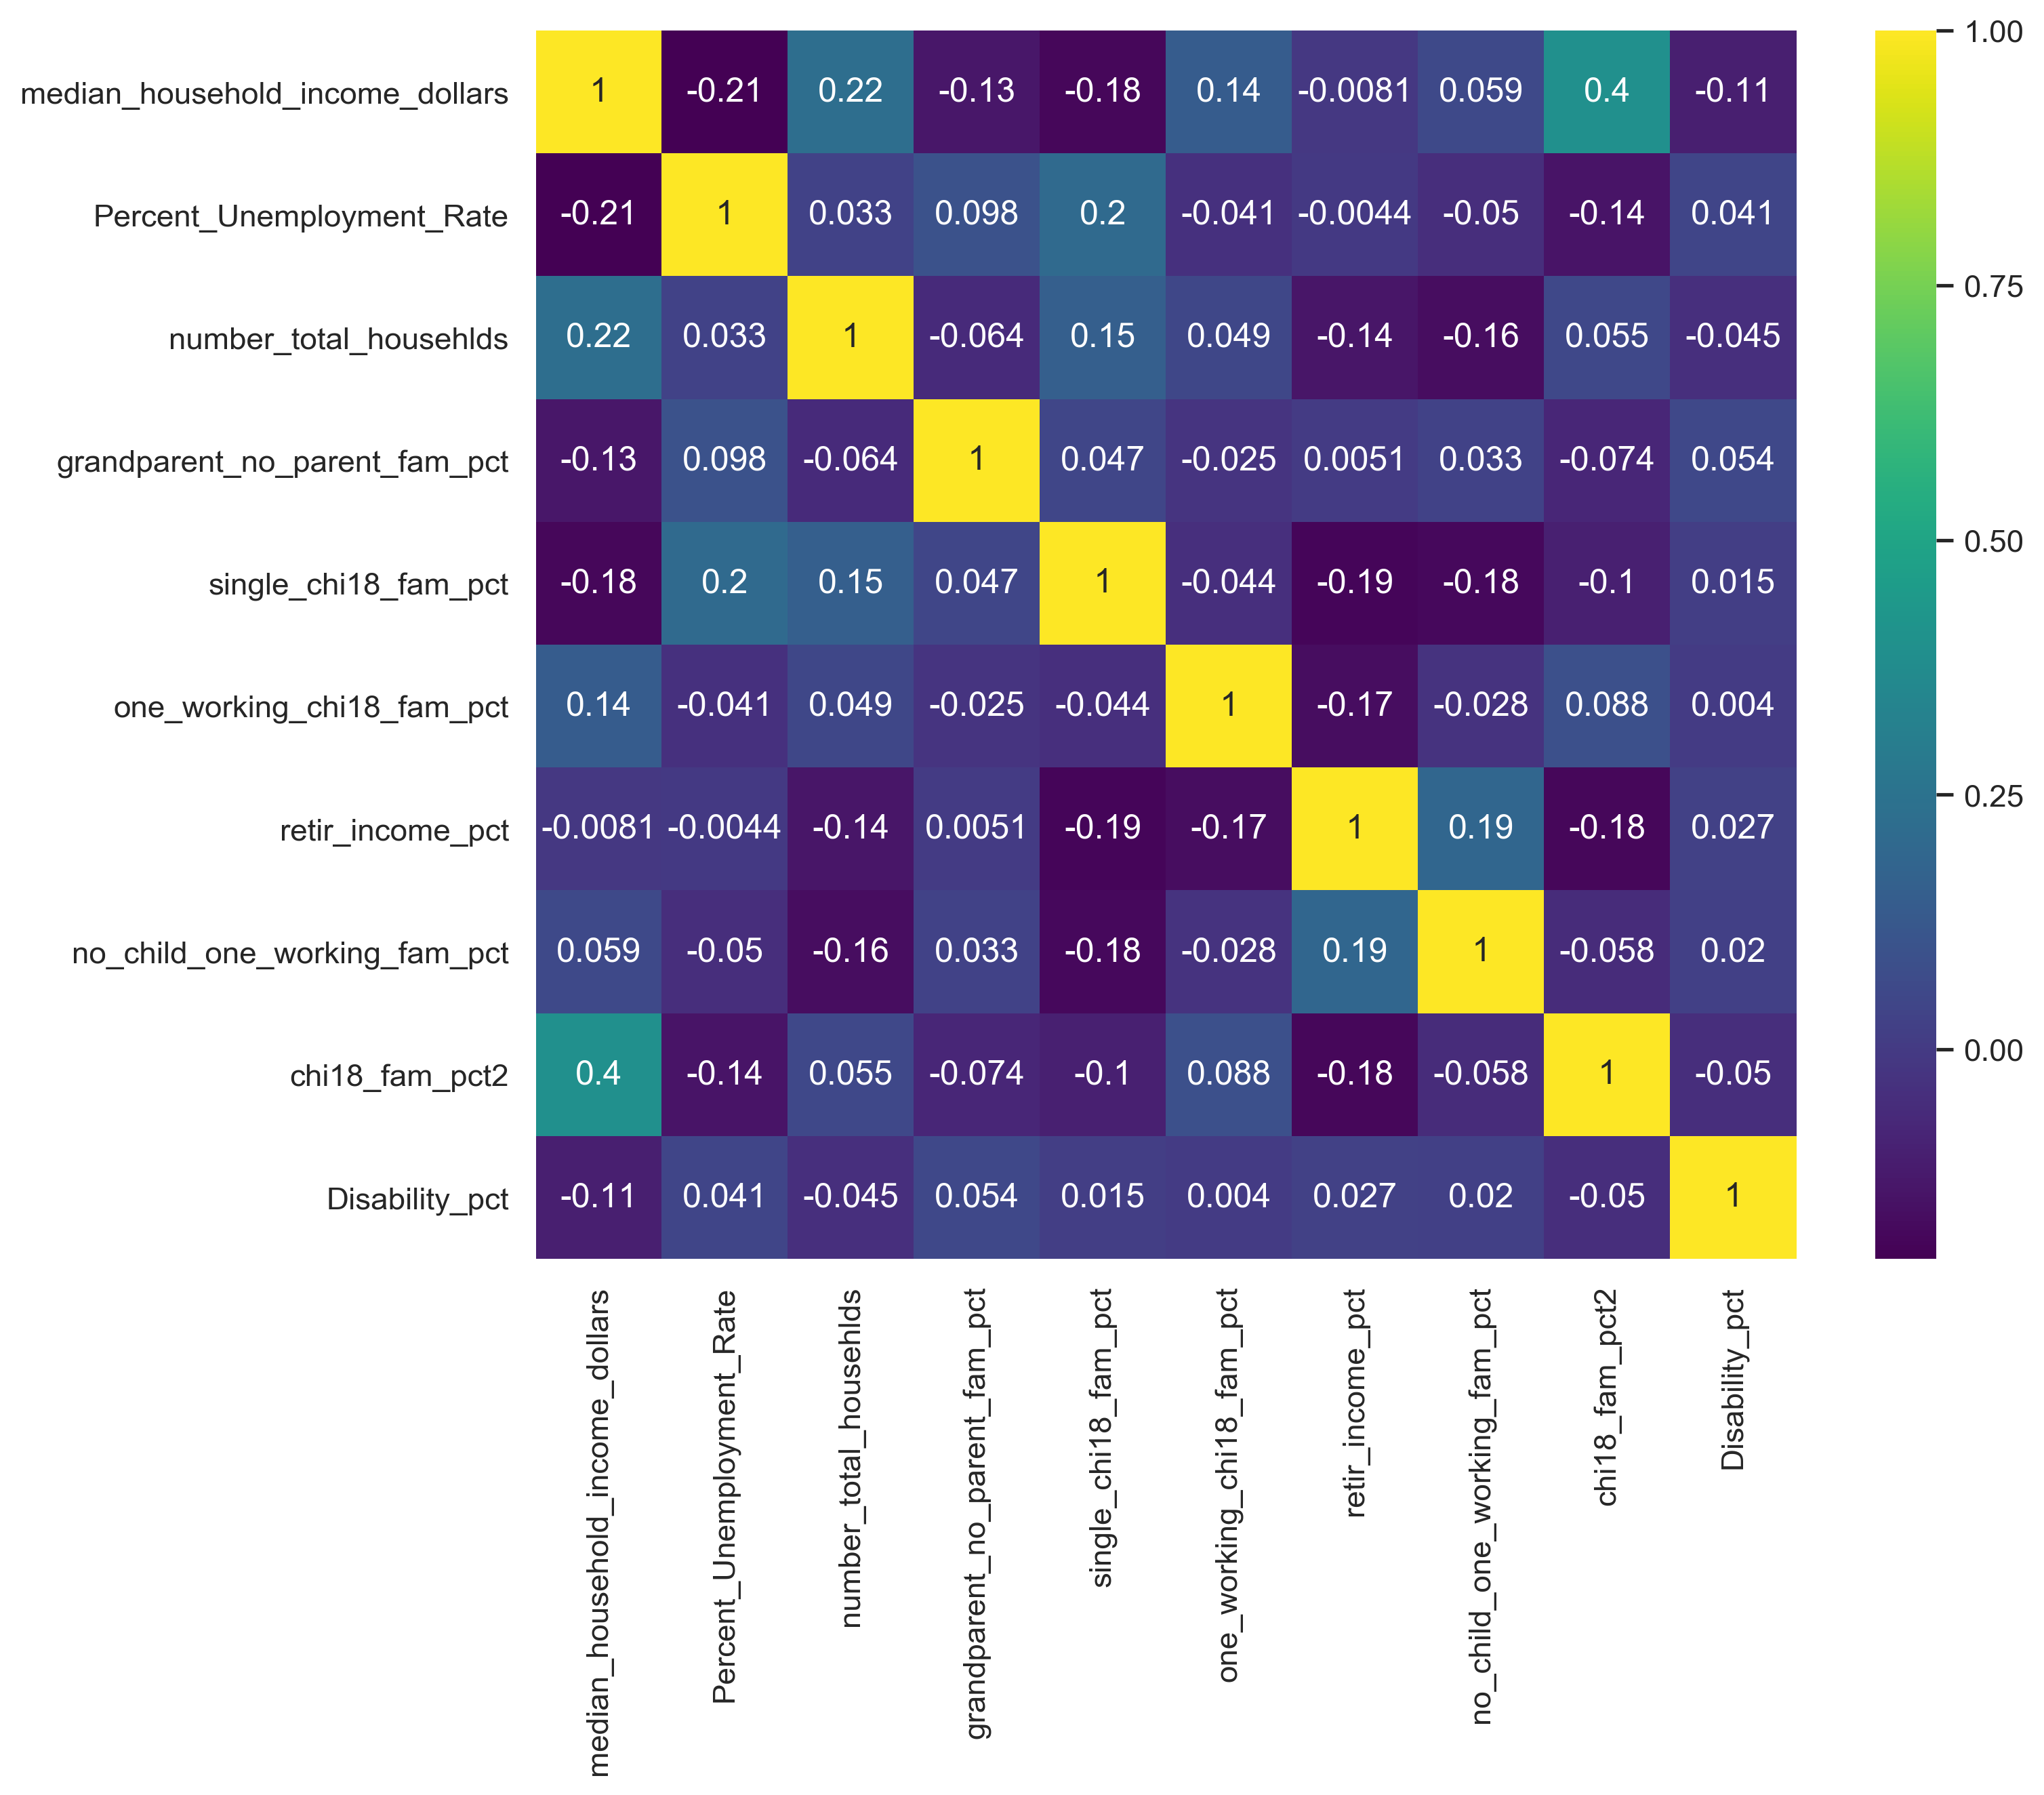

In [9]:
# corr heatmap
sns.set()
plt.figure(figsize = (10,8),dpi = 300)
sns.heatmap(t1cor, cmap = 'viridis', annot = True)

In [10]:
def plotall(k,df):
    f2, axes = plt.subplots(k, figsize=(10, 20))
    for i,col in enumerate(df.columns):
        axes[i].hist(df[col], bins = 50)
        axes[i].set_title(col)
    plt.tight_layout()

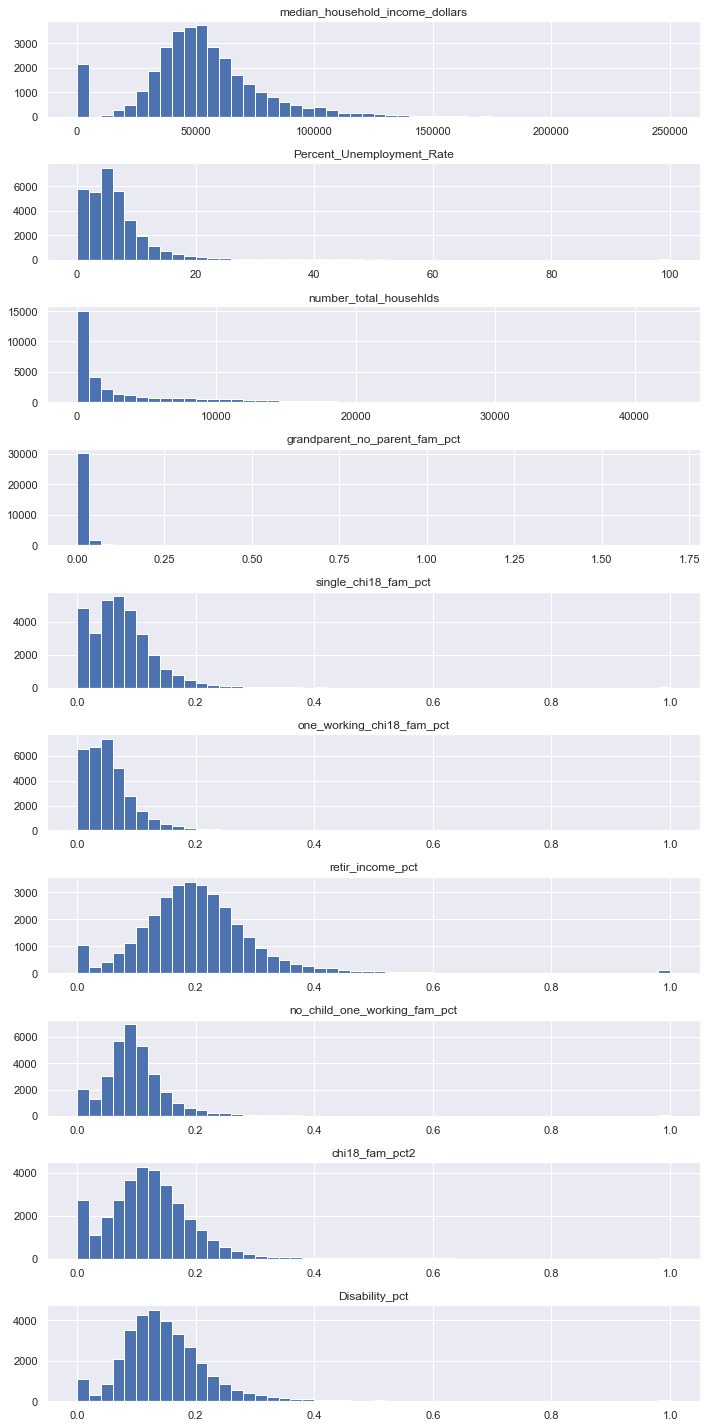

In [11]:
plotall(set2.shape[1], set2)

### Preprocessing

In [12]:
# take log

def takelog(x):
    try:
        return mh.log10(x)
    except:
        return float(0)

# winsorize - cap outliers 

def winsoriz_my(s, limit):
    a = s.quantile(limit[0])
    b = s.quantile(limit[1])
    return s.clip(lower=a, upper=b)

# score computing 

def weight(k,list1):
    sumk = 0
    for a,b in enumerate(list1):
        sumk += k[a]*b
    return sumk

In [13]:
def preprocessing_1(df1):
    df = df1.copy()
    
    # take log
    # winsorize - clip at quantiles
    # flip negative factors
    
    df['number_total_househlds'] = winsoriz_my(df['number_total_househlds'].apply(takelog),(0.03,1))
    df2 = df.drop(['grandparent_no_parent_fam_pct', 'number_total_househlds'], axis = 1)
    df3 = df2.apply(winsoriz_my, axis = 0, limit = (0,0.95)).join(df['number_total_househlds'])
    df3['Percent_Unemployment_Rate'] = df3['Percent_Unemployment_Rate'].apply(lambda x:-x)
    df3['retir_income_pct'] = df3['retir_income_pct'].apply(lambda x:-x)
    scaled = MinMaxScaler(feature_range=(0,10)).fit_transform(df3)
    df4 = pd.DataFrame(scaled, columns=df3.columns)
    
    return df4

### Assign Weight 

In [14]:
def assign_weight(df1):
    df = df1.copy()
    # assign weight
    a1_equal_weight = df.apply(weight, list1 = [1/9]*9, axis = 1)
    a2 = df.apply(weight, list1 = [1/8]*2+[1/20]*5+[1/4]+[1/4], axis = 1)
    a3 = df.apply(weight, list1 = [1/9]*2+[1/15]*5+[1/3]+[1/9], axis = 1)
    a4 = df.apply(weight, list1 = [1/4]*2+[1/14]*7, axis = 1)
    
    df['score1_all_equal'] = a1_equal_weight
    df['score2_compo2'] = a4
    df['score3_compo3'] = a3
    df['score4_compo4'] = a2
    
    return df

In [15]:
set3=assign_weight(preprocessing_1(set2))

In [16]:
set3.head()

,median_household_income_dollars,Percent_Unemployment_Rate,single_chi18_fam_pct,one_working_chi18_fam_pct,retir_income_pct,no_child_one_working_fam_pct,chi18_fam_pct2,Disability_pct,number_total_househlds,score1_all_equal,score2_compo2,score3_compo3,score4_compo4
0,1.163242,0.000000,8.456986,2.763671,6.095782,3.790037,3.326491,5.085004,7.438675,4.235543,2.930571,4.279634,4.497973
1,1.601844,0.000000,6.442930,3.402690,6.449684,4.449326,3.401086,2.689065,8.445554,4.098020,2.920485,3.622447,4.191171
2,1.646862,0.000000,8.403286,2.951210,5.681244,3.236643,3.259292,0.640584,8.962826,3.864661,2.778507,2.961161,3.783294
3,1.324514,2.638037,7.063947,3.651919,4.425447,5.772290,3.097743,3.677818,6.037379,4.187677,3.399677,3.937799,4.124686
4,1.854241,0.981595,6.206791,3.114467,5.509643,3.984598,3.619255,3.489439,8.017351,4.086375,3.133355,3.864706,4.352915


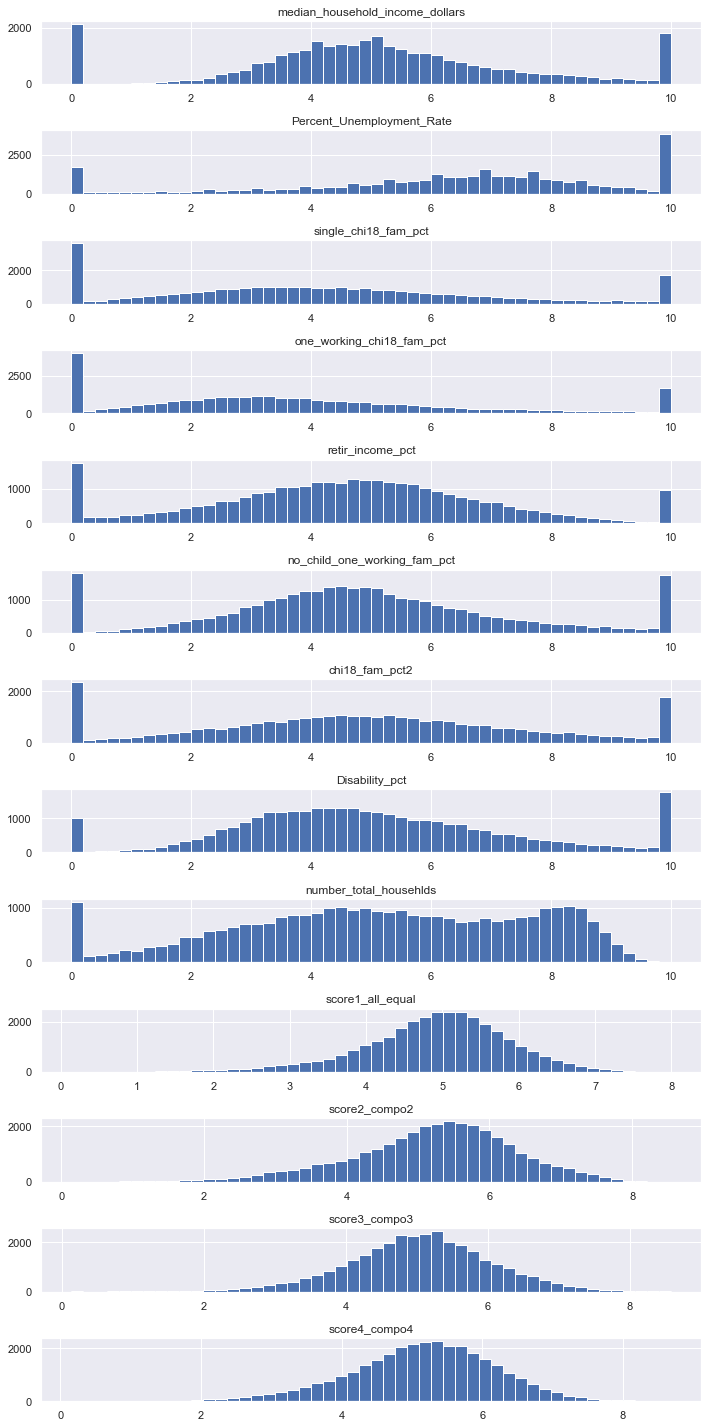

In [17]:
# preprocessed data and score overview

plotall(set3.shape[1], set3)

### Combine and Save

In [20]:
set4 = pd.concat([set3, set1['zipcode']], axis = 1)

In [21]:
set4.to_csv('Scaled features and predicted Score1.csv', index = False)

### Next Step

Because there's 0 label available in this learning process. It's a more of an unsupervised learning process. Therefore, next, clustering will be performed to see the natural clustering behavior of the zipcodes based on collected features. If zipcodes fall into the same cluster happen to have similar scores, the accuracy of assigned score is substantiated.